# **Task 1: Dataset Distillation with Attention Matching**

In this task, you will use the dataset distillation with attention matching [36] to learn a synthetically small dataset for the MNIST and MHIST datasets, train networks from scratch on the condensed images, and then evaluate them on the real testing data. This is one of the fundamental frameworks for dealing with dataset distillation in computer vision classification tasks while decreasing the computational costs. Please follow the instructions below to become acquainted with this algorithm.

## **1. Basic Concepts. Read the paper “Efficient Dataset Distillation with Attention Matching” [36] carefully, and then answer the following questions:**

**(a) What is the purpose of using Dataset Distillation in this paper?**

The purpose of using Dataset Distillation in this paper is to reduce the size of a large dataset by creating a small synthetic dataset that retains the most critical information from the original data which help reduce the computational cost of training deep learning models while maintaining a good performance.

---


**(b) What are the advantages of their methodology over state-of-the-art? Explain your rationale.**

The methodology offers superior efficiency with up to 100x reduced training costs, improved accuracy on datasets like CIFAR100 and ImageNet-1K, cross-architecture generalization, and enhanced memory efficiency for tasks like continual learning and neural architecture search, outperforming state-of-the-art by eliminating complex bi-level optimization and reducing computational overhead.


---


**(c) What novelty did they contribute compared to their prior methods?**

The key novelty in this paper is the use of Spatial Attention Matching for aligning the attention maps of synthetic and real data across multiple layers of neural network.


---


**(d) Explain in full detail the methodologies of the paper.**

It uses a Spatial Attention Matching module to align attention maps from real and synthetic data at multiple layers of randomly initialized neural networks. Additionally, it employs Maximum Mean Discrepancy loss to reduce disparities between high-level features of real and synthetic data. The combined loss is optimized via stochastic gradient descent.


---


**(e) Explain the usefulness of the methodology in machine learning applications (at least two applications).**

The two key applications of Dataset Distillation are Continual Learning and Neural Architecture Search (NAS).
In Continual Learning, models need to retain knowledge from previous tasks while learning new ones. Dataset distillation helps by storing small, distilled datasets as memory buffers, allowing the model to efficiently retain information with minimal memory usage and computational cost.
In Neural Architecture Search, exploring various neural architectures can be computationally expensive. Dataset distillation creates smaller proxy datasets, reducing the computational burden and speeding up the evaluation process, making NAS more efficient and scalable.

## **2. Dataset Distillation Learning. Select one of the six architecture backbones provided in the networks.ipynb file and follow the below steps on the MNIST and MHIST datasets to implement Dataset Distillation with Attention Matching algorithm (Suggestion: Use ConvNet-3 and ConvNet- 7 for MNIST and MHIST, respectively.):**

**(a) Train the selected model with the original dataset and report the classification accuracy along with floating-point operations per second (FLOPs) for the test set. Use SGD as an optimizer with a cosine annealing scheduler with an initial learning rate of 0.01 for 20 epochs. (For more information on experimental setting, look at the implementation details of [51]) These scores give you the upper bound benchmark evaluation.**

In [ ]:
!pip install torchprofile

In [ ]:
import torchprofile

In [ ]:
import zipfile
from torchvision import transforms

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import cv2
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ECE1512_ProjectA')

import os
os.chdir('/content/drive/MyDrive/ECE1512_ProjectA')

import zipfile
import io
from PIL import Image
import pandas as pd

In [ ]:
import networks
import utils

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class Args:
    def __init__(self):
        # Device settings
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Training hyperparameters
        self.epochs = 20
        self.batch_size = 256
        self.learning_rate = 0.01
        self.weight_decay = 0.0005

        # Model settings
        self.model_name = 'ConvNet'   # Change based on model choice
        self.channel = 3              # 1 for grayscale, 3 for RGB
        self.num_classes = 10         # Adjust for dataset used
        self.im_size = (32, 32)       # Image size based on dataset
        self.net_width = 128          # Width of ConvNet layers
        self.net_depth = 3            # Depth of ConvNet layers
        self.net_act = 'relu'         # Activation function
        self.net_norm = 'instancenorm' # Normalization method
        self.net_pooling = 'avgpooling' # Pooling method

        # Scheduler settings
        self.scheduler_T_max = self.epochs
        self.lr_scheduler = 'CosineAnnealingLR'

        # DiffAugment settings
        self.dsa = True                    # Enable DiffAugment
        self.dsa_strategy = 'color_flip_crop'  # DiffAugment strategy
        self.dsa_param = utils.ParamDiffAug()    # Parameters for DiffAugment

        # Data augmentation parameters
        self.dc_aug_param = {
            'crop': 4,
            'scale': 0.2,
            'rotate': 45,
            'noise': 0.001,
            'strategy': 'crop_scale_rotate'
        }

        # Evaluation settings
        self.eval_mode = 'M'  # Evaluation mode for cross-architecture tests
        self.dis_metric = 'cos'  # Distance metric for match_loss function

        # Dataset-specific settings
        self.dataset = 'MNIST'
        self.data_path = './data'

        # Hyperparameters for synthetic dataset training
        self.lr_net = 0.01
        self.epoch_eval_train = 10
        self.batch_train = 128

        # Synthetic data learning parameters
        self.K = 100                  # Number of random weight initializations
        self.T = 10                   # Number of training iterations
        self.ηS = 0.1                 # Learning rate for condensed samples
        self.ζS = 1                   # Optimization steps for condensed samples
        self.ηθ = 0.01                # Learning rate for model
        self.ζθ = 50                  # Optimization steps for model
        self.λ = 0.01                 # Task balance parameter

    def update(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [ ]:
args = Args()

In [ ]:
# Train with GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Transform for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

In [ ]:
# Transform for MHIST
transform_mhist = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [ ]:
# Load the MNIST dataset
mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_mnist)

mnist_train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=1000, shuffle=False)

In [ ]:
# Initilize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Tran the ConvNet3 on mnist dataset
print("Training ConvNet3 on MNIST dataset without distillation.\n")

optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mnist_train_loader, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet3 on MNIST dataset without distillation.

Epoch 1/20, Loss: 0.51, Accuracy: 0.85
Epoch 2/20, Loss: 0.22, Accuracy: 0.94
Epoch 3/20, Loss: 0.16, Accuracy: 0.95
Epoch 4/20, Loss: 0.13, Accuracy: 0.96
Epoch 5/20, Loss: 0.12, Accuracy: 0.97
Epoch 6/20, Loss: 0.10, Accuracy: 0.97
Epoch 7/20, Loss: 0.09, Accuracy: 0.97
Epoch 8/20, Loss: 0.09, Accuracy: 0.97
Epoch 9/20, Loss: 0.08, Accuracy: 0.98
Epoch 10/20, Loss: 0.08, Accuracy: 0.98
Epoch 11/20, Loss: 0.08, Accuracy: 0.98
Epoch 12/20, Loss: 0.07, Accuracy: 0.98
Epoch 13/20, Loss: 0.07, Accuracy: 0.98
Epoch 14/20, Loss: 0.07, Accuracy: 0.98
Epoch 15/20, Loss: 0.07, Accuracy: 0.98
Epoch 16/20, Loss: 0.07, Accuracy: 0.98
Epoch 17/20, Loss: 0.06, Accuracy: 0.98
Epoch 18/20, Loss: 0.06, Accuracy: 0.98
Epoch 19/20, Loss: 0.06, Accuracy: 0.98
Epoch 20/20, Loss: 0.06, Accuracy: 0.98

Total training time: 324.73440170288086


In [ ]:
# Save trained ConvNet3 model
PATH = "convnet3_mnist_model.pth"

torch.save(convnet3_mnist.state_dict(), PATH)
print(f"Model saved to {PATH}")

Model saved to convnet3_mnist_model.pth


In [ ]:
print("Evaluate the ConvNet3 on the MNIST test dataset.")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"\nTest Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet3 on the MNIST test dataset.

Test Loss: 0.06, Test Accuracy: 0.98


In [ ]:
# Calculate FLOPs for ConvNet3
dummy_input = torch.randn(1, 1, 28, 28).to(device)
flops = torchprofile.profile_macs(convnet3_mnist, dummy_input)
print(f'FLOPs for ConvNet-3: {flops}')

FLOPs for ConvNet-3: 3292160


In [ ]:
'''
# To reload save model
modelsavename = "xxxx"
# Load the state dictionary using strict=False to ignore size mismatches
model.load_state_dict(torch.load(modelsavename), strict=False)
'''

'\n# To reload save model\nmodelsavename = "xxxx"\n# Load the state dictionary using strict=False to ignore size mismatches\nmodel.load_state_dict(torch.load(modelsavename), strict=False)\n'

In [ ]:
# Load MHIST from zip
class MHISTDatasetFromZip(Dataset):
    def __init__(self, zip_path, labels_file, partition, transform=None):
        self.zip_path = zip_path
        self.labels_df = pd.read_csv(labels_file)
        self.partition = partition
        self.transform = transform

        # Filter based on the partition (train/test)
        self.labels_df = self.labels_df[self.labels_df['Partition'] == self.partition]

        # Load the zip file
        self.zip_file = zipfile.ZipFile(zip_path, 'r')

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get image name and label from the CSV file
        img_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]

        # Extract the image from the zip file
        with self.zip_file.open(f"images/{img_name}") as file:
            img = Image.open(io.BytesIO(file.read())).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, 0 if label == 'SSA' else 1

    def __del__(self):
        # Close the zip file
        self.zip_file.close()

In [ ]:
# Define the path to images.zip and the annotations.csv
zip_path = '/content/drive/MyDrive/ECE1512_ProjectA/images.zip'
annotations_file = '/content/drive/MyDrive/ECE1512_ProjectA/annotations.csv'

# Create training and testing datasets
mhist_train_dataset = MHISTDatasetFromZip(zip_path=zip_path, labels_file=annotations_file, partition='train', transform=transform_mhist)
mhist_test_dataset = MHISTDatasetFromZip(zip_path=zip_path, labels_file=annotations_file, partition='test', transform=transform_mhist)

mhist_train_loader = DataLoader(mhist_train_dataset, batch_size=32, shuffle=True)
mhist_test_loader = DataLoader(mhist_test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
print("Training ConvNet7 on MHIST dataset without distillation.\n")
optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist_train_loader, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet7 on MHIST dataset without distillation.

Epoch 1/20, Loss: 0.59, Accuracy: 0.69
Epoch 2/20, Loss: 0.53, Accuracy: 0.73
Epoch 3/20, Loss: 0.51, Accuracy: 0.73
Epoch 4/20, Loss: 0.48, Accuracy: 0.76
Epoch 5/20, Loss: 0.48, Accuracy: 0.77
Epoch 6/20, Loss: 0.45, Accuracy: 0.78
Epoch 7/20, Loss: 0.45, Accuracy: 0.78
Epoch 8/20, Loss: 0.44, Accuracy: 0.78
Epoch 9/20, Loss: 0.43, Accuracy: 0.79
Epoch 10/20, Loss: 0.41, Accuracy: 0.81
Epoch 11/20, Loss: 0.41, Accuracy: 0.82
Epoch 12/20, Loss: 0.40, Accuracy: 0.81
Epoch 13/20, Loss: 0.37, Accuracy: 0.84
Epoch 14/20, Loss: 0.37, Accuracy: 0.83
Epoch 15/20, Loss: 0.36, Accuracy: 0.84
Epoch 16/20, Loss: 0.37, Accuracy: 0.83
Epoch 17/20, Loss: 0.35, Accuracy: 0.84
Epoch 18/20, Loss: 0.35, Accuracy: 0.84
Epoch 19/20, Loss: 0.34, Accuracy: 0.84
Epoch 20/20, Loss: 0.33, Accuracy: 0.86

Total training time: 190.70577955245972


In [ ]:
print("Evaluate the ConvNet7 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet7 on the MHIST test dataset.

Test Loss: 0.33, Test Accuracy: 0.86


In [ ]:
# Calculate FLOPs for ConvNet7
dummy_input = torch.randn(1, 3, 256, 256).to(device)
flops = torchprofile.profile_macs(convnet7_mhist, dummy_input)
print(f'FLOPs for ConvNet-7: {flops}')

FLOPs for ConvNet-7: 260696832


In [ ]:
# Save trained ConvNet7 model
PATH = "convnet7_mhist_model.pth"

torch.save(convnet7_mhist.state_dict(), PATH)
print(f"Model saved to {PATH}")

Model saved to convnet7_mhist_model.pth


---



**(b) Learn the synthetic dataset S using the selected model and Attention Matching algorithm. For initialization of condensed images, randomly select from real training images. The experimental setup can be found in Table 1.**

Table 1: Experimental setup for learning the synthetic dataset S with Attention Matching algorithm. The hyper-parameters K, T, ηS, ζS, ηθ, and ζθ denote the number of random weight initializations, number of iterations, the learning rate for the condensed samples, the number of optimization steps for the condensed samples, the learning rate for the model, and the number of optimization steps for the model, respectively. Attention Matching additionally introduces a task balance parameter λ, feel free to tweak this parameter for better performance – recommended setting around 0.01.

**Table 1: Experimental setup for learning the synthetic dataset S with Attention Matching algorithm.**

| Dataset | K  | T   | ηS  | ζS  | ηθ  | ζθ | Optimizer | # images/class | Minibatch size |
|---------|----|-----|-----|-----|-----|----|-----------|----------------|----------------|
| MNIST   | 100| 1.0 | 0.1 | 1   | 0.01| 50 | SGD       | 10             | 256            |
| MHIST   | 200| 10  | 0.1 | 1   | 0.01| 50 | SGD       | 50             | 128            |


**(c) Provide the visualization of condensed images per class for both MNIST and MHIST datasets. Do you think these condensed images are recognizable? Support your explanations.**

Yes, the condensed images appear to be recognizable. During the condensation process, each image is distilled to retain the most salient features that represent its class. As a result, the condensed images for both MNIST and MHIST datasets capture the main structural patterns and distinguishing characteristics of each class, making them visually similar to the original images.

Display condensed MNIST image (initilzed with random real images)



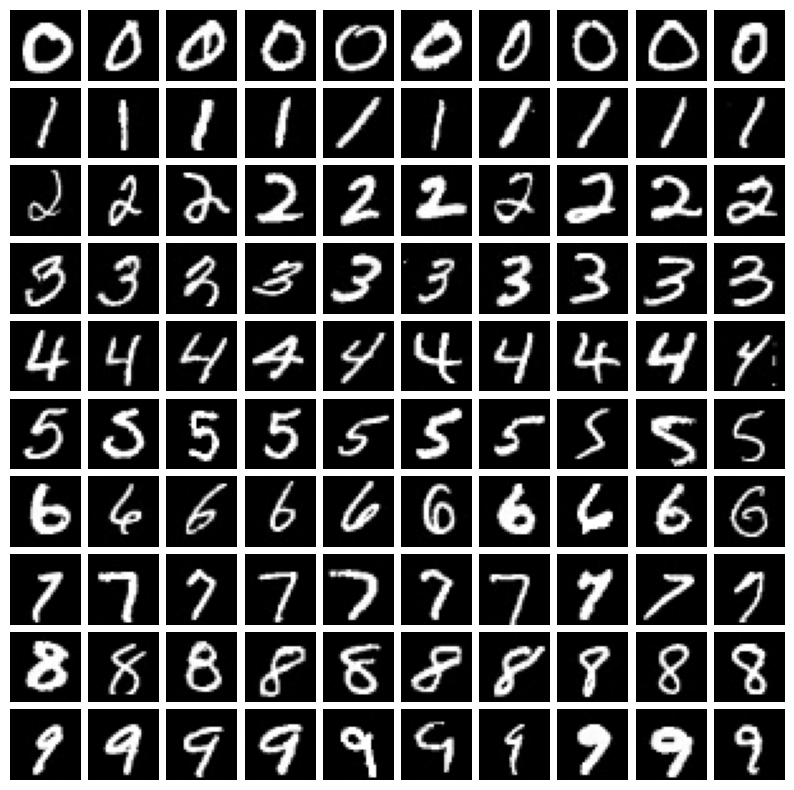

In [ ]:
# Display condensed mnist image (initilzed with random real images)
print("Display condensed MNIST image (initilzed with random real images)\n")

image_dir = "real_mnist"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

Display condensed MHIST image (initilzed with random real images)



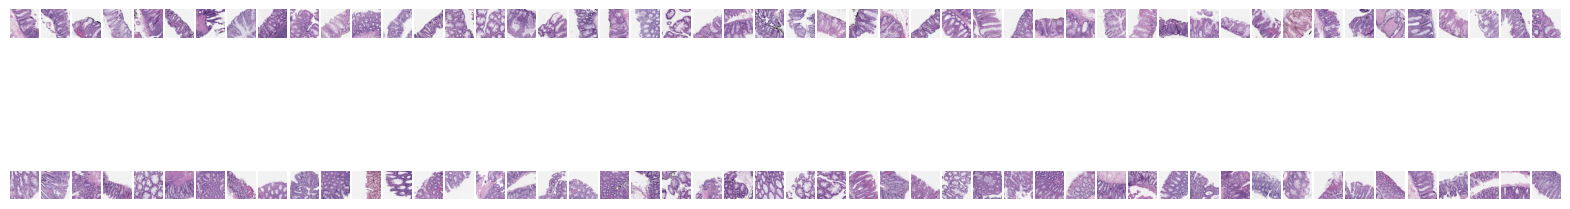

In [ ]:
print("Display condensed MHIST image (initilzed with random real images)\n")

image_dir = "real_mhist"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

**(d) Repeat 2(b)(c) while while the condensed images are initialized with Gaussian noise. Discuss in full detail the qualitative and quantitative results you have achieved. Are the results and visualizations are comparable with parts 2b and 2c?**

Condensed synthetic images from Gaussian initialization are not recognizable in the same way as real images, as they often lack the fidelity and structural integrity of randomly selected real images.

Furher, training on synthetic data derived from Gaussian noise often results in lower classification accuracy compared to using real images due to limited visual fidelity and diversity in the synthetic dataset.

While synthetic data condensation provides a compact and computationally efficient representation, it may not be an adequate substitute for real data in applications where high recognition accuracy is required.
In summary, while synthetic images generated from Gaussian initialization can be helpful for quick, low-cost training, they fall short in both recognizability and performance when compared to randomly initialized real images.








Display condensed MNIST image (initilzed with Gaussian noise)



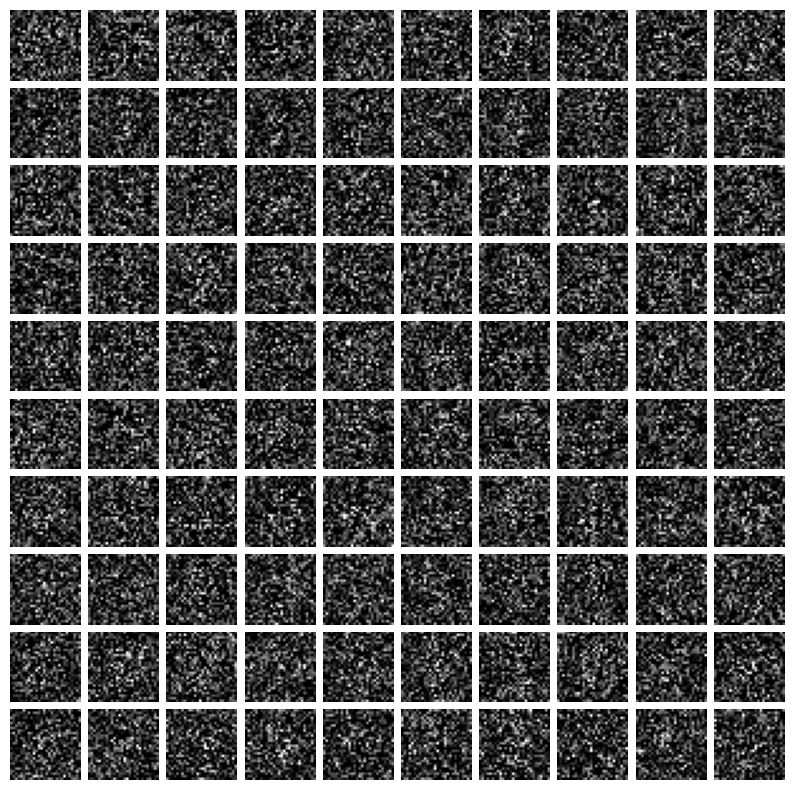

In [ ]:
# Display condensed mnist image (initilzed with Gaussian noise)
print("Display condensed MNIST image (initilzed with Gaussian noise)\n")

image_dir = "gaussian_mnist"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for idx, image_file in enumerate(image_files[:100]):
    # Load the image in grayscale
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    row = idx // 10
    col = idx % 10

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()

Display condensed MHIST image (initilzed with Gaussian noise)



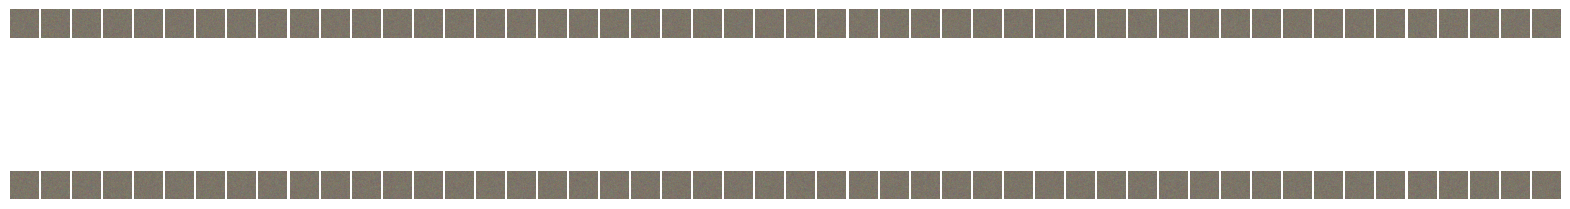

In [ ]:
print("Display condensed MHIST image (initilzed with Gaussian noise)\n")

image_dir = "gaussian_mhist"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

fig, axes = plt.subplots(2, 50, figsize=(20, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for idx, image_file in enumerate(image_files[:100]):
    # Load the image in RGB
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    row = idx // 50
    col = idx % 50

    axes[row, col].imshow(image_rgb)
    axes[row, col].axis('off')

plt.show()

**(e) Now that you have had a chance to understand, learn, and visualize the condensed dataset, we can train the selected network from scratch on the condensed images. Train the selected network on a learned synthetic dataset (with 100 training images), then evaluate it on the real testing data. Compare the test accuracy performance and the training time with part 2a. Explain your results. (For a fair comparison, you should use the exact same experimental setting as part 2a)**

The training time significantly reduced when using the condensed dataset for training compared to the full dataset. The accuracy for models trained on condensed images initialized from random real images achieved approximately the same performance on the test dataset, while the ones initialized with Gaussian noise achieved a slightly lower accuracy. The lower accuracy in the Gaussian-initialized set is likely due to the lack of structural information, which makes it harder for the network to learn effective representations.

In [ ]:
# Class for condensed datasets
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        image = Image.open(img_path).convert("L")

        label = int(self.image_files[idx].split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Load condensed images (initialzed from random real images)
image_dir = "real_mnist"

transform = transforms.Compose([
    transforms.ToTensor(),
])

real_mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

real_mnist = DataLoader(real_mnist, batch_size=16, shuffle=True)

for images, labels in real_mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([1, 0, 4, 3, 8, 4, 1, 4, 6, 1, 9, 6, 5, 9, 2, 4])


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 model on condensed mnist images
print("Training ConvNet3 on MNIST dataset initialized from real training images.\n")

optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', real_mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet3 on MNIST dataset initialized from real training images.

Epoch 1/20, Loss: 2.52, Accuracy: 0.09
Epoch 2/20, Loss: 2.38, Accuracy: 0.11
Epoch 3/20, Loss: 2.13, Accuracy: 0.17
Epoch 4/20, Loss: 1.79, Accuracy: 0.42
Epoch 5/20, Loss: 1.75, Accuracy: 0.41
Epoch 6/20, Loss: 1.57, Accuracy: 0.54
Epoch 7/20, Loss: 1.47, Accuracy: 0.51
Epoch 8/20, Loss: 1.31, Accuracy: 0.64
Epoch 9/20, Loss: 1.25, Accuracy: 0.68
Epoch 10/20, Loss: 1.10, Accuracy: 0.76
Epoch 11/20, Loss: 1.04, Accuracy: 0.80
Epoch 12/20, Loss: 1.04, Accuracy: 0.80
Epoch 13/20, Loss: 1.11, Accuracy: 0.69
Epoch 14/20, Loss: 0.86, Accuracy: 0.84
Epoch 15/20, Loss: 1.11, Accuracy: 0.68
Epoch 16/20, Loss: 0.99, Accuracy: 0.82
Epoch 17/20, Loss: 0.92, Accuracy: 0.81
Epoch 18/20, Loss: 0.94, Accuracy: 0.82
Epoch 19/20, Loss: 0.92, Accuracy: 0.73
Epoch 20/20, Loss: 0.70, Accuracy: 0.95

Total training time: 4.37654447555542


In [ ]:
print("Evaluate the ConvNet3 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet3 on the MNIST test dataset.

Test Loss: 0.70, Test Accuracy: 0.95


In [ ]:
# Load condensed images (initialzed from gaussian noise)
image_dir = "gaussian_mnist"

transform = transforms.Compose([
    transforms.ToTensor(),
])

gaussian_mnist = CustomImageDataset(image_dir=image_dir, transform=transform)

gaussian_mnist = DataLoader(gaussian_mnist, batch_size=16, shuffle=True)

for images, labels in gaussian_mnist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 1, 28, 28])
Batch of labels: tensor([7, 2, 4, 9, 0, 9, 6, 9, 7, 9, 8, 9, 2, 2, 5, 4])


In [ ]:
# Initialize the ConvNet3 model
channel = 1
num_classes = 10
net_width = 32
net_depth = 3
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (28, 28)

convnet3_mnist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet3 on condensed mnist (Initialized from gaussian noise)
print("Training ConvNet3 on MNIST dataset initialized from Gaussian noise.\n")

optimizer = torch.optim.SGD(convnet3_mnist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', gaussian_mnist, convnet3_mnist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet3 on MNIST dataset initialized from Gaussian noise.

Epoch 1/20, Loss: 2.44, Accuracy: 0.12
Epoch 2/20, Loss: 2.66, Accuracy: 0.10
Epoch 3/20, Loss: 2.44, Accuracy: 0.07
Epoch 4/20, Loss: 2.34, Accuracy: 0.16
Epoch 5/20, Loss: 2.34, Accuracy: 0.14
Epoch 6/20, Loss: 2.34, Accuracy: 0.18
Epoch 7/20, Loss: 2.22, Accuracy: 0.18
Epoch 8/20, Loss: 2.19, Accuracy: 0.24
Epoch 9/20, Loss: 2.09, Accuracy: 0.26
Epoch 10/20, Loss: 2.08, Accuracy: 0.25
Epoch 11/20, Loss: 2.12, Accuracy: 0.21
Epoch 12/20, Loss: 1.97, Accuracy: 0.35
Epoch 13/20, Loss: 1.89, Accuracy: 0.41
Epoch 14/20, Loss: 2.03, Accuracy: 0.32
Epoch 15/20, Loss: 1.95, Accuracy: 0.34
Epoch 16/20, Loss: 1.76, Accuracy: 0.61
Epoch 17/20, Loss: 1.90, Accuracy: 0.48
Epoch 18/20, Loss: 1.94, Accuracy: 0.48
Epoch 19/20, Loss: 1.95, Accuracy: 0.40
Epoch 20/20, Loss: 1.78, Accuracy: 0.62

Total training time: 4.7148778438568115


In [ ]:
print("Evaluate the ConvNet3 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, convnet3_mnist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet3 on the MNIST test dataset.

Test Loss: 1.78, Test Accuracy: 0.62


In [ ]:
class MhistImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])

        image = Image.open(img_path).convert("RGB")

        label = int(self.image_files[idx].split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Load condensed images (initialzed from random real images)
image_dir = "real_mhist"

transform = transforms.Compose([
    transforms.ToTensor(),
])

real_mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

real_mhist = DataLoader(real_mhist, batch_size=16, shuffle=True)

for images, labels in real_mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0])


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset
print("Training ConvNet7 on MHIST dataset initialized from real training images.\n")

optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', real_mhist, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet7 on MHIST dataset initialized from real training images.

Epoch 1/20, Loss: 0.76, Accuracy: 0.48
Epoch 2/20, Loss: 0.70, Accuracy: 0.53
Epoch 3/20, Loss: 0.65, Accuracy: 0.62
Epoch 4/20, Loss: 0.67, Accuracy: 0.56
Epoch 5/20, Loss: 0.61, Accuracy: 0.67
Epoch 6/20, Loss: 0.57, Accuracy: 0.69
Epoch 7/20, Loss: 0.65, Accuracy: 0.59
Epoch 8/20, Loss: 0.61, Accuracy: 0.65
Epoch 9/20, Loss: 0.56, Accuracy: 0.68
Epoch 10/20, Loss: 0.57, Accuracy: 0.74
Epoch 11/20, Loss: 0.62, Accuracy: 0.65
Epoch 12/20, Loss: 0.54, Accuracy: 0.73
Epoch 13/20, Loss: 0.54, Accuracy: 0.76
Epoch 14/20, Loss: 0.53, Accuracy: 0.70
Epoch 15/20, Loss: 0.60, Accuracy: 0.70
Epoch 16/20, Loss: 0.50, Accuracy: 0.80
Epoch 17/20, Loss: 0.48, Accuracy: 0.78
Epoch 18/20, Loss: 0.49, Accuracy: 0.77
Epoch 19/20, Loss: 0.47, Accuracy: 0.82
Epoch 20/20, Loss: 0.47, Accuracy: 0.76

Total training time: 10.849185705184937


In [ ]:
print("Evaluate the ConvNet7 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet7 on the MHIST test dataset.

Test Loss: 0.47, Test Accuracy: 0.76


In [ ]:
# Load condensed images (initialzed from random real images)
image_dir = "gaussian_mhist"

transform = transforms.Compose([
    transforms.ToTensor(),
])

gaussian_mhist_dataset = MhistImageDataset(image_dir=image_dir, transform=transform)

gaussian_mhist_dataloader = DataLoader(gaussian_mhist_dataset, batch_size=16, shuffle=True)

for images, labels in gaussian_mhist_dataloader:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 256, 256])
Batch of labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1])


In [ ]:
# Initialize the ConvNet7 model
channel = 3
num_classes = 2
net_width = 32
net_depth = 7
net_act = 'relu'
net_norm = 'batchnorm'
net_pooling = 'maxpooling'
im_size = (256, 256)

convnet7_mhist = networks.ConvNet(channel, num_classes, net_width, net_depth, net_act, net_norm, net_pooling, im_size).to(device)

In [ ]:
# Train the ConvNet7 model on Mhist dataset

print("Training ConvNet7 on MHIST dataset initialized from Gaussian noise.\n")

optimizer = torch.optim.SGD(convnet7_mhist.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', gaussian_mhist_dataloader, convnet7_mhist, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ConvNet7 on MHIST dataset initialized from Gaussian noise.

Epoch 1/20, Loss: 0.72, Accuracy: 0.52
Epoch 2/20, Loss: 0.76, Accuracy: 0.50
Epoch 3/20, Loss: 0.89, Accuracy: 0.45
Epoch 4/20, Loss: 0.81, Accuracy: 0.51
Epoch 5/20, Loss: 0.75, Accuracy: 0.52
Epoch 6/20, Loss: 0.65, Accuracy: 0.59
Epoch 7/20, Loss: 0.58, Accuracy: 0.73
Epoch 8/20, Loss: 0.79, Accuracy: 0.50
Epoch 9/20, Loss: 0.69, Accuracy: 0.55
Epoch 10/20, Loss: 0.65, Accuracy: 0.59
Epoch 11/20, Loss: 0.68, Accuracy: 0.51
Epoch 12/20, Loss: 0.67, Accuracy: 0.64
Epoch 13/20, Loss: 0.69, Accuracy: 0.60
Epoch 14/20, Loss: 0.64, Accuracy: 0.65
Epoch 15/20, Loss: 0.55, Accuracy: 0.68
Epoch 16/20, Loss: 0.62, Accuracy: 0.60
Epoch 17/20, Loss: 0.63, Accuracy: 0.59
Epoch 18/20, Loss: 0.58, Accuracy: 0.64
Epoch 19/20, Loss: 0.57, Accuracy: 0.73
Epoch 20/20, Loss: 0.61, Accuracy: 0.66

Total training time: 8.24413013458252


In [ ]:
print("Evaluate the ConvNet7 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, convnet7_mhist, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ConvNet7 on the MHIST test dataset.

Test Loss: 0.61, Test Accuracy: 0.66


## **3. Cross-architecture Generalization. Another key advantage of the dataset distillation approaches is that the condensed images learned using one architecture can be used to train another, unseen one. Here you learned the synthetic datasets for the MNIST and MHIST over the 4 selected model in part 2b. Once the condensed sets are synthesized, train another network from networks.ipynb file and evaluate its cross-architecture performance in terms of classification accuracy on the test sets. Were your condensed datasets successful in cross-architecture generalization on the MNIST and MHIST datasets? Support all your answers with detailed reasons and results. (Hint: use the utils.ipynb file)**

To evaluate the cross-architecture performance of the condensed datasets, I trained a ResNet-18 model on synthetic datasets synthesized through dataset distillation. The goal was to determine whether these condensed datasets could generalize effectively on a different architecture than the ones used to create them. I measured performance in terms of classification accuracy on the MNIST and MHIST test sets.

**Results Summary**

The ResNet-18 model achieved the following accuracies on the test sets:

*   MNIST initialized from real images: 55%
*   MNIST initialized from Gaussian noise: 23%
*   MHIST initialized from real images: 99%
*   MHIST initialized from Gaussian noise: 86%

These results provide insights into the effectiveness of the condensed datasets in generalizing across architectures.

**Analysis of MNIST Results**

Accuracy with Real Images (55%): The 55% accuracy on MNIST initialized from real images indicates a moderate level of cross-architecture generalization. While ResNet-18 could identify some of the MNIST features, the relatively low accuracy suggests that the condensed dataset might not fully capture all essential features. This could be due to the complexity of the handwritten digits in MNIST, where slight variations or missing details in the distilled dataset can significantly affect classification accuracy. Hence, while the condensed dataset shows some cross-architecture generalization, it may not be optimal for achieving high accuracy on architectures different from those used for synthesis.

Accuracy with Gaussian Noise (23%): The low accuracy of 23% on MNIST initialized from Gaussian noise highlights the limited cross-architecture generalization of this particular dataset. Since the initial images were noisy, it appears that essential MNIST features were not effectively distilled, resulting in poor performance when applied to ResNet-18. This further suggests that initializing from Gaussian noise might be less effective for complex datasets like MNIST.

An additional factor contributing to the low accuracy is the slower convergence of ResNet-18 on MNIST. From the training curve, it is evident that the loss is still decreasing and accuracy is still increasing; however, due to the standardized training parameters set for fair comparison across models, ResNet-18 may not have reached its full performance potential within the allocated epochs. Given more training time, the accuracy might have continued to improve, reflecting the model’s ability to further adapt to the distilled dataset.

**Analysis of MHIST Results**

Accuracy with Real Images (99%): The MHIST dataset initialized from real images performed really well, achieving 99% accuracy on ResNet-18. This high accuracy demonstrates strong cross-architecture generalization, indicating that the distilled dataset effectively preserved the key features of MHIST. Unlike MNIST, MHIST may have simpler or more distinct features that were easier to capture during distillation, making the synthetic dataset highly transferable across architectures.

Accuracy with Gaussian Noise (86%): The MHIST dataset initialized from Gaussian noise also performed well, achieving 86% accuracy on ResNet-18. It demonstrates that even with an initial noisy input, the condensed dataset preserved significant enough features for ResNet-18 to generalize effectively.


In [ ]:
# Load condensed images (initialzed from random real images)
image_dir = "real_mhist"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

real_mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

real_mhist = DataLoader(real_mhist, batch_size=16, shuffle=True)

for images, labels in real_mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 224, 224])
Batch of labels: tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0])


In [ ]:
# Load condensed images (initialzed from gausian noise)
image_dir = "gaussian_mhist"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

gaussian_mhist = MhistImageDataset(image_dir=image_dir, transform=transform)

gaussian_mhist = DataLoader(gaussian_mhist, batch_size=16, shuffle=True)

for images, labels in gaussian_mhist:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    break

Batch of images: torch.Size([16, 3, 224, 224])
Batch of labels: tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1])


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)

        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
mnist_resnet = ResNet18(num_classes=10).to(device)

In [ ]:
# Train the ResNet18 model on Mnist dataset
print("Training ResNet18 on MNIST dataset initialized from real images.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', real_mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on MNIST dataset initialized from real images.

Epoch 1/20, Loss: 2.48, Accuracy: 0.13
Epoch 2/20, Loss: 2.39, Accuracy: 0.19
Epoch 3/20, Loss: 2.31, Accuracy: 0.22
Epoch 4/20, Loss: 2.32, Accuracy: 0.20
Epoch 5/20, Loss: 2.29, Accuracy: 0.27
Epoch 6/20, Loss: 1.99, Accuracy: 0.29
Epoch 7/20, Loss: 1.63, Accuracy: 0.45
Epoch 8/20, Loss: 2.13, Accuracy: 0.37
Epoch 9/20, Loss: 1.84, Accuracy: 0.38
Epoch 10/20, Loss: 1.74, Accuracy: 0.39
Epoch 11/20, Loss: 1.92, Accuracy: 0.36
Epoch 12/20, Loss: 1.32, Accuracy: 0.58
Epoch 13/20, Loss: 1.74, Accuracy: 0.49
Epoch 14/20, Loss: 1.56, Accuracy: 0.45
Epoch 15/20, Loss: 1.16, Accuracy: 0.57
Epoch 16/20, Loss: 1.23, Accuracy: 0.65
Epoch 17/20, Loss: 1.37, Accuracy: 0.50
Epoch 18/20, Loss: 1.32, Accuracy: 0.55
Epoch 19/20, Loss: 1.37, Accuracy: 0.53
Epoch 20/20, Loss: 1.25, Accuracy: 0.55

Total training time: 5.745745897293091


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 1.25, Test Accuracy: 0.55


In [ ]:
mnist_resnet = ResNet18(num_classes=10).to(device)

In [ ]:
# Train the ResNet18 model on Mnist dataset

print("Training ResNet18 on MNIST dataset initialized from Gaussian noise.\n")
optimizer = torch.optim.SGD(mnist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', gaussian_mnist, mnist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on MNIST dataset initialized from Gaussian noise.

Epoch 1/20, Loss: 2.69, Accuracy: 0.11
Epoch 2/20, Loss: 2.79, Accuracy: 0.13
Epoch 3/20, Loss: 2.84, Accuracy: 0.14
Epoch 4/20, Loss: 2.66, Accuracy: 0.14
Epoch 5/20, Loss: 2.68, Accuracy: 0.15
Epoch 6/20, Loss: 2.65, Accuracy: 0.11
Epoch 7/20, Loss: 2.63, Accuracy: 0.13
Epoch 8/20, Loss: 2.72, Accuracy: 0.06
Epoch 9/20, Loss: 2.42, Accuracy: 0.18
Epoch 10/20, Loss: 2.52, Accuracy: 0.12
Epoch 11/20, Loss: 2.31, Accuracy: 0.18
Epoch 12/20, Loss: 2.34, Accuracy: 0.13
Epoch 13/20, Loss: 2.32, Accuracy: 0.16
Epoch 14/20, Loss: 2.18, Accuracy: 0.20
Epoch 15/20, Loss: 2.27, Accuracy: 0.20
Epoch 16/20, Loss: 2.21, Accuracy: 0.22
Epoch 17/20, Loss: 2.28, Accuracy: 0.16
Epoch 18/20, Loss: 2.16, Accuracy: 0.27
Epoch 19/20, Loss: 2.19, Accuracy: 0.23
Epoch 20/20, Loss: 2.21, Accuracy: 0.23

Total training time: 5.4256696701049805


In [ ]:
print("Evaluate the ResNet18 on the MNIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mnist_test_loader, mnist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MNIST test dataset.

Test Loss: 2.21, Test Accuracy: 0.23


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        # Load pre-trained ResNet-18
        self.model = models.resnet18(pretrained=True)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on MHIST dataset initialized from random real images.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', real_mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on MHIST dataset initialized from random real images.

Epoch 1/20, Loss: 0.73, Accuracy: 0.61
Epoch 2/20, Loss: 0.58, Accuracy: 0.69
Epoch 3/20, Loss: 0.67, Accuracy: 0.74
Epoch 4/20, Loss: 0.73, Accuracy: 0.67
Epoch 5/20, Loss: 0.34, Accuracy: 0.85
Epoch 6/20, Loss: 0.32, Accuracy: 0.87
Epoch 7/20, Loss: 0.19, Accuracy: 0.97
Epoch 8/20, Loss: 0.28, Accuracy: 0.87
Epoch 9/20, Loss: 0.19, Accuracy: 0.93
Epoch 10/20, Loss: 0.15, Accuracy: 0.96
Epoch 11/20, Loss: 0.16, Accuracy: 0.94
Epoch 12/20, Loss: 0.09, Accuracy: 1.00
Epoch 13/20, Loss: 0.14, Accuracy: 0.95
Epoch 14/20, Loss: 0.07, Accuracy: 1.00
Epoch 15/20, Loss: 0.09, Accuracy: 1.00
Epoch 16/20, Loss: 0.10, Accuracy: 0.97
Epoch 17/20, Loss: 0.09, Accuracy: 0.99
Epoch 18/20, Loss: 0.10, Accuracy: 0.99
Epoch 19/20, Loss: 0.08, Accuracy: 0.99
Epoch 20/20, Loss: 0.07, Accuracy: 0.99

Total training time: 13.9525785446167


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.07, Test Accuracy: 0.99


In [ ]:
mhist_resnet = ResNet18(num_classes=2).to(device)
print("Training ResNet18 on MHIST dataset initialized from Gaussian noise.\n")
optimizer = torch.optim.SGD(mhist_resnet.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', gaussian_mhist, mhist_resnet, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training ResNet18 on MHIST dataset initialized from Gaussian noise.

Epoch 1/20, Loss: 0.99, Accuracy: 0.44
Epoch 2/20, Loss: 0.74, Accuracy: 0.55
Epoch 3/20, Loss: 0.75, Accuracy: 0.59
Epoch 4/20, Loss: 0.81, Accuracy: 0.51
Epoch 5/20, Loss: 0.58, Accuracy: 0.70
Epoch 6/20, Loss: 0.59, Accuracy: 0.65
Epoch 7/20, Loss: 0.69, Accuracy: 0.61
Epoch 8/20, Loss: 0.71, Accuracy: 0.70
Epoch 9/20, Loss: 0.56, Accuracy: 0.68
Epoch 10/20, Loss: 0.76, Accuracy: 0.59
Epoch 11/20, Loss: 0.48, Accuracy: 0.77
Epoch 12/20, Loss: 0.44, Accuracy: 0.80
Epoch 13/20, Loss: 0.42, Accuracy: 0.79
Epoch 14/20, Loss: 0.43, Accuracy: 0.81
Epoch 15/20, Loss: 0.34, Accuracy: 0.84
Epoch 16/20, Loss: 0.30, Accuracy: 0.88
Epoch 17/20, Loss: 0.40, Accuracy: 0.79
Epoch 18/20, Loss: 0.49, Accuracy: 0.76
Epoch 19/20, Loss: 0.37, Accuracy: 0.88
Epoch 20/20, Loss: 0.35, Accuracy: 0.86

Total training time: 11.326666593551636


In [ ]:
print("Evaluate the ResNet18 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_resnet, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the ResNet18 on the MHIST test dataset.

Test Loss: 0.35, Test Accuracy: 0.86


## **4. Application. Apply your synthetic small datasets to one of the machine learning applications you proposed in part 1e (These papers are helpful: [37, 5, 41, 6, 10, 26, 12, 52, 47, 32, 28, 39, 16, 19, 18, 40, 25, 46]). Discuss in full detail the qualitative and quantitative results you have achieved.**

**Application of Synthetic Small Datasets to VGG16 Training on MHIST**

In this application, we aimed to demonstrate the resource efficiency of using synthetic small datasets, focusing on training time and model performance. Specifically, we trained a VGG16 model on the MHIST dataset using two versions of the data:

1.   The original dataset (not condensed)
2.   A condensed synthetic dataset initialized from real images, with only 100 samples.

Our objective was to evaluate the qualitative and quantitative benefits of the synthetic dataset in terms of training time reduction and accuracy retention.

**Experiment Details**

The VGG16 model was trained on the original MHIST dataset to establish a baseline. For comparison, we then trained the model on the synthetic dataset with only 100 images, distilled from the original dataset. By comparing the training times and accuracies, we assessed the trade-off between resource efficiency and performance.

**Results Summary**

Original Dataset (Not Condensed)

*   Training time: 212 seconds
*   Accuracy: 92%

Condensed Synthetic Dataset (100 Images)

*   Training time: 14 seconds
*   Accuracy: 85%

**Analysis of Results**

1. Training Time Reduction: The synthetic dataset significantly reduced the training time. Training VGG16 on the original dataset took 212 seconds, while training on the condensed dataset took only 14 seconds. This approximately 15x reduction in training time demonstrates the efficiency advantage of using condensed datasets. In applications where computational resources are limited, such as edge devices or mobile applications, this reduction could be highly valuable.
2. Accuracy Comparison: The accuracy achieved using the condensed dataset was 85%, slightly lower than the 92% accuracy obtained with the original dataset. This 7% decrease in accuracy highlights a trade-off between training efficiency and performance. However, retaining an 85% accuracy with only 100 training samples shows that the synthetic dataset captures essential features of the MHIST data effectively, even with a much smaller dataset size. This level of accuracy may be acceptable for applications where resource efficiency is prioritized over marginal performance gains.
3. Qualitative Assessment: From a qualitative perspective, the synthetic dataset preserves enough core features to achieve high accuracy despite a substantial reduction in data volume. This result suggests that the dataset distillation process is effective in maintaining relevant data characteristics, enabling cross-architecture generalization when applied to VGG16. The condensed dataset’s performance also implies that VGG16 can successfully learn and generalize from a small, representative dataset, making it feasible for rapid training iterations in scenarios that do not require peak accuracy.

In summary, applying the synthetic dataset to the VGG16 model on MHIST showcased significant training resource savings. These results demonstrate that condensed datasets can serve as an effective solution to reduce training resources without drastically sacrificing performance. This approach is especially beneficial in resource-constrained environments or applications requiring quick training cycles. In future work, further refining the condensation process could help improve accuracy while retaining the training efficiency achieved with the synthetic dataset.

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2, num_channels=1):
        super(VGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)

        if num_channels != 3:
            self.model.features[0] = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)

        self.model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        num_features = self.model.classifier[0].in_features

        self.model.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on MHIST dataset without distillation.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', mhist_train_loader, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on MHIST dataset without distillation.

Epoch 1/20, Loss: 0.56, Accuracy: 0.71
Epoch 2/20, Loss: 0.50, Accuracy: 0.73
Epoch 3/20, Loss: 0.48, Accuracy: 0.74
Epoch 4/20, Loss: 0.45, Accuracy: 0.79
Epoch 5/20, Loss: 0.43, Accuracy: 0.79
Epoch 6/20, Loss: 0.42, Accuracy: 0.80
Epoch 7/20, Loss: 0.40, Accuracy: 0.82
Epoch 8/20, Loss: 0.38, Accuracy: 0.82
Epoch 9/20, Loss: 0.33, Accuracy: 0.85
Epoch 10/20, Loss: 0.32, Accuracy: 0.86
Epoch 11/20, Loss: 0.30, Accuracy: 0.87
Epoch 12/20, Loss: 0.27, Accuracy: 0.88
Epoch 13/20, Loss: 0.26, Accuracy: 0.89
Epoch 14/20, Loss: 0.23, Accuracy: 0.90
Epoch 15/20, Loss: 0.24, Accuracy: 0.90
Epoch 16/20, Loss: 0.21, Accuracy: 0.91
Epoch 17/20, Loss: 0.20, Accuracy: 0.92
Epoch 18/20, Loss: 0.19, Accuracy: 0.92
Epoch 19/20, Loss: 0.19, Accuracy: 0.92
Epoch 20/20, Loss: 0.18, Accuracy: 0.92

Total training time: 212.16333436965942


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.18, Test Accuracy: 0.92


In [ ]:
mhist_vgg16 = VGG16(num_classes=2, num_channels=3).to(device)

In [ ]:
print("Training VGG16 on MHIST dataset initialized from random real images.\n")
optimizer = torch.optim.SGD(mhist_vgg16.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=args.scheduler_T_max)

start = time.time()
for epoch in range(args.epochs):
    train_loss, train_acc = utils.epoch('train', real_mhist, mhist_vgg16, optimizer, criterion, args=args, aug=args.dsa)
    print(f"Epoch {epoch+1}/{args.epochs}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}")

    scheduler.step()

end = time.time()
print(f"\nTotal training time: {end - start}")

Training VGG16 on MHIST dataset initialized from random real images.

Epoch 1/20, Loss: 0.69, Accuracy: 0.51
Epoch 2/20, Loss: 0.68, Accuracy: 0.58
Epoch 3/20, Loss: 0.68, Accuracy: 0.61
Epoch 4/20, Loss: 0.67, Accuracy: 0.58
Epoch 5/20, Loss: 0.66, Accuracy: 0.58
Epoch 6/20, Loss: 0.63, Accuracy: 0.66
Epoch 7/20, Loss: 0.62, Accuracy: 0.67
Epoch 8/20, Loss: 0.59, Accuracy: 0.73
Epoch 9/20, Loss: 0.54, Accuracy: 0.72
Epoch 10/20, Loss: 0.51, Accuracy: 0.74
Epoch 11/20, Loss: 0.50, Accuracy: 0.78
Epoch 12/20, Loss: 0.54, Accuracy: 0.78
Epoch 13/20, Loss: 0.62, Accuracy: 0.67
Epoch 14/20, Loss: 0.49, Accuracy: 0.84
Epoch 15/20, Loss: 0.45, Accuracy: 0.84
Epoch 16/20, Loss: 0.46, Accuracy: 0.85
Epoch 17/20, Loss: 0.43, Accuracy: 0.84
Epoch 18/20, Loss: 0.38, Accuracy: 0.85
Epoch 19/20, Loss: 0.40, Accuracy: 0.82
Epoch 20/20, Loss: 0.41, Accuracy: 0.85

Total training time: 14.115869760513306


In [ ]:
print("Evaluate the VGG16 on the MHIST test dataset.\n")
test_loss, test_acc = utils.epoch('test', mhist_test_loader, mhist_vgg16, optimizer, criterion, args=args, aug=False)
print(f"Test Loss: {train_loss:.2f}, Test Accuracy: {train_acc:.2f}")

Evaluate the VGG16 on the MHIST test dataset.

Test Loss: 0.41, Test Accuracy: 0.85


References

[1] Dataset distillation,. https://www.tongzhouwang.info/. Available access on 2022 Jun 20.

[2] Towards lossless dataset distillation via difficulty-aligned trajectory matching,. https://
gzyaftermath.github.io/DATM/.

[3] George Cazenavette, Tongzhou Wang, Antonio Torralba, Alexei A Efros, and Jun-Yan Zhu. Dataset distillation by matching training trajectories. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 4750–4759, 2022. https://arxiv.org/abs/2203. 11932.

[4] George Cazenavette, Tongzhou Wang, Antonio Torralba, Alexei A Efros, and Jun-Yan Zhu. Gener- alizing dataset distillation via deep generative prior. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 3739–3748, 2023.

[5] Dingfan Chen, Raouf Kerkouche, and Mario Fritz. Private set generation with discriminative infor- mation. arXiv preprint arXiv:2211.04446, 2022. https://arxiv.org/pdf/2211.04446.pdf.

[6] Justin Cui, Ruochen Wang, Si Si, and Cho-Jui Hsieh. Dc-bench: Dataset condensation benchmark. arXiv preprint arXiv:2207.09639, 2022. https://openreview.net/pdf?id=Bs8iFQ7AM6.

[7] Justin Cui, Ruochen Wang, Si Si, and Cho-Jui Hsieh. Scaling up dataset distillation to imagenet-1k with constant memory. In International Conference on Machine Learning, pages 6565–6590. PMLR, 2023.

[8] Jia Deng, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, and Li Fei-Fei. Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition, pages 248–255. Ieee, 2009. https://ieeexplore.ieee.org/document/5206848.

[9] Zhiwei Deng and Olga Russakovsky. Remember the past: Distilling datasets into addressable mem- ories for neural networks. arXiv preprint arXiv:2206.02916, 2022. https://arxiv.org/abs/2206. 02916.

[10] Tian Dong, Bo Zhao, and Lingjuan Lyu. Privacy for free: How does dataset condensation help pri- vacy? arXiv preprint arXiv:2206.00240, 2022. https://proceedings.mlr.press/v162/dong22c/ dong22c.pdf.

[11] Spyros Gidaris and Nikos Komodakis. Dynamic few-shot visual learning without forgetting. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 4367–4375, 2018. https://arxiv.org/abs/1804.09458.

[12] Jack Goetz and Ambuj Tewari. Federated learning via synthetic data. arXiv preprint arXiv:2008.04489, 2020. https://arxiv.org/abs/2008.04489.

[13] Ziyao Guo, Kai Wang, George Cazenavette, Hui Li, Kaipeng Zhang, and Yang You. Towards lossless dataset distillation via difficulty-aligned trajectory matching. arXiv preprint arXiv:2310.05773, 2023.

[14] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recog- nition. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 770–778, 2016. https://arxiv.org/abs/1512.03385.

[15] Geoffrey Hinton, Oriol Vinyals, Jeff Dean, et al. Distilling the knowledge in a neural network. arXiv preprint arXiv:1503.02531, 2(7), 2015. https://arxiv.org/abs/1503.02531.

[16] Shengyuan Hu, Jack Goetz, Kshitiz Malik, Hongyuan Zhan, Zhe Liu, and Yue Liu. Fedsynth: Gradient compression via synthetic data in federated learning. arXiv preprint arXiv:2204.01273, 2022. https://arxiv.org/pdf/2204.01273.pdf.

[17] Zixuan Jiang, Jiaqi Gu, Mingjie Liu, and David Z Pan. Delving into effective gradient matching for dataset condensation. arXiv preprint arXiv:2208.00311, 2022. https://arxiv.org/abs/2208. 00311.

[18] Wei Jin, Xianfeng Tang, Haoming Jiang, Zheng Li, Danqing Zhang, Jiliang Tang, and Bing Yin. Condensing graphs via one-step gradient matching. In Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining, pages 720–730, 2022. https://arxiv.org/ abs/2206.07746.

[19] Wei Jin, Lingxiao Zhao, Shichang Zhang, Yozen Liu, Jiliang Tang, and Neil Shah. Graph condensa- tion for graph neural networks. arXiv preprint arXiv:2110.07580, 2021. https://arxiv.org/pdf/ 2110.07580.pdf.

[20] Balhae Kim, Jungwon Choi, Seanie Lee, Yoonho Lee, Jung-Woo Ha, and Juho Lee. On divergence measures for bayesian pseudocoresets. arXiv preprint arXiv:2210.06205, 2022. https://arxiv. org/abs/2210.06205.

[21] Jang-Hyun Kim, Jinuk Kim, Seong Joon Oh, Sangdoo Yun, Hwanjun Song, Joonhyun Jeong, Jung- Woo Ha, and Hyun Oh Song. Dataset condensation via efficient synthetic-data parameterization. arXiv preprint arXiv:2205.14959, 2022. https://proceedings.mlr.press/v162/kim22c.html.

[22] Alex Krizhevsky, Geoffrey Hinton, et al. Learning multiple layers of features from tiny images. 2009. https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf.

[23] Yann LeCun, L ́eon Bottou, Yoshua Bengio, and Patrick Haffner. Gradient-based learning ap- plied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998. http://vision. stanford.edu/cs598_spring07/papers/Lecun98.pdf.

[24] Saehyung Lee, Sanghyuk Chun, Sangwon Jung, Sangdoo Yun, and Sungroh Yoon. Dataset conden- sation with contrastive signals. arXiv preprint arXiv:2202.02916, 2022. https://arxiv.org/abs/ 2202.02916.

[25] Guang Li, Ren Togo, Takahiro Ogawa, and Miki Haseyama. Soft-label anonymous gastric x-ray image distillation. In 2020 IEEE International Conference on Image Processing (ICIP), pages 305– 309. IEEE, 2020. https://ieeexplore.ieee.org/document/9191357.

[26] Guang Li, Ren Togo, Takahiro Ogawa, and Miki Haseyama. Dataset distillation using parameter pruning. arXiv preprint arXiv:2209.14609, 2022. https://arxiv.org/abs/2209.14609.

[27] Zekai Li, Ziyao Guo, Wangbo Zhao, Tianle Zhang, Zhi-Qi Cheng, Samir Khaki, Kaipeng Zhang, Ahmad Sajedi, Konstantinos N Plataniotis, Kai Wang, and Yang You. Prioritize alignment in dataset distillation, 2024.

[28] Ping Liu, Xin Yu, and Joey Tianyi Zhou. Meta knowledge condensation for federated learning. arXiv preprint arXiv:2209.14851, 2022. https://arxiv.org/pdf/2209.14851.pdf.

[29] Songhua Liu, Kai Wang, Xingyi Yang, Jingwen Ye, and Xinchao Wang. Dataset distillation via factorization. arXiv preprint arXiv:2210.16774, 2022. https://arxiv.org/abs/2210.16774.

[30] Noel Loo, Ramin Hasani, Alexander Amini, and Daniela Rus. Efficient dataset distillation using random feature approximation. arXiv preprint arXiv:2210.12067, 2022. https://openreview.net/ forum?id=h8Bd7Gm3muB.

[31] Jonathan Lorraine, Paul Vicol, and David Duvenaud. Optimizing millions of hyperparameters by implicit differentiation. In International Conference on Artificial Intelligence and Statistics, pages 1540–1552. PMLR, 2020. https://arxiv.org/abs/1911.02590.

[32] Wojciech Masarczyk and Ivona Tautkute. Reducing catastrophic forgetting with learning on syn- thetic data. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recog- nition Workshops, pages 252–253, 2020. https://arxiv.org/abs/2004.14046.

[33] Timothy Nguyen, Zhourong Chen, and Jaehoon Lee. Dataset meta-learning from kernel ridge- regression. arXiv preprint arXiv:2011.00050, 2020. https://arxiv.org/abs/2011.00050.

[34] Timothy Nguyen, Roman Novak, Lechao Xiao, and Jaehoon Lee. Dataset distillation with infinitely wide convolutional networks. Advances in Neural Information Processing Systems, 34:5186–5198, 2021. https://arxiv.org/abs/2107.13034.

[35] Parsa Nooralinejad, Ali Abbasi, Soheil Kolouri, and Hamed Pirsiavash. Pranc: Pseudo random networks for compacting deep models. arXiv preprint arXiv:2206.08464, 2022. https://arxiv. org/abs/2206.08464.

[36] Ahmad Sajedi, Samir Khaki, Ehsan Amjadian, Lucy Z Liu, Yuri A Lawryshyn, and Konstantinos N Plataniotis. Datadam: Efficient dataset distillation with attention matching. In Proceedings of the IEEE/CVF International Conference on Computer Vision, pages 17097–17107, 2023.

[37] Mattia Sangermano, Antonio Carta, Andrea Cossu, and Davide Bacciu. Sample condensation in online continual learning. In 2022 International Joint Conference on Neural Networks (IJCNN), pages 01–08. IEEE, 2022. https://ieeexplore.ieee.org/document/9892299.

[38] Karen Simonyan and Andrew Zisserman. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556, 2014. https://arxiv.org/abs/1409.1556.

[39] Rui Song, Dai Liu, Dave Zhenyu Chen, Andreas Festag, Carsten Trinitis, Martin Schulz, and Alois Knoll. Federated learning via decentralized dataset distillation in resource-constrained edge envi- ronments. arXiv preprint arXiv:2208.11311, 2022. https://arxiv.org/pdf/2208.11311.pdf.

[40] Felipe Petroski Such, Aditya Rawal, Joel Lehman, Kenneth Stanley, and Jeffrey Clune. Generative teaching networks: Accelerating neural architecture search by learning to generate synthetic training data. In International Conference on Machine Learning, pages 9206–9216. PMLR, 2020. http: //proceedings.mlr.press/v119/such20a/such20a.pdf.

[41] Ilia Sucholutsky and Matthias Schonlau. Secdd: Efficient and secure method for remotely training neural networks. arXiv preprint arXiv:2009.09155, 2020. https://arxiv.org/pdf/2009.09155. pdf.

[42] Paul Vicol, Jonathan P Lorraine, Fabian Pedregosa, David Duvenaud, and Roger B Grosse. On implicit bias in overparameterized bilevel optimization. In International Conference on Machine Learning, pages 22234–22259. PMLR, 2022. https://proceedings.mlr.press/v162/vicol22a. html.

[43] Kai Wang, Bo Zhao, Xiangyu Peng, Zheng Zhu, Shuo Yang, Shuo Wang, Guan Huang, Hakan Bilen, Xinchao Wang, and Yang You. Cafe: Learning to condense dataset by aligning features. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 12196–12205, 2022. https://arxiv.org/abs/2203.01531.

[44] Tongzhou Wang, Jun-Yan Zhu, Antonio Torralba, and Alexei A Efros. Dataset distillation. arXiv preprint arXiv:1811.10959, 2018. https://arxiv.org/abs/1811.10959.

[45] Jerry Wei, Arief Suriawinata, Bing Ren, Xiaoying Liu, Mikhail Lisovsky, Louis Vaickus, Charles Brown, Michael Baker, Naofumi Tomita, Lorenzo Torresani, et al. A petri dish for histopathology image analysis. In International Conference on Artificial Intelligence in Medicine, pages 11–24. Springer, 2021. https://arxiv.org/abs/2101.12355.

[46] Felix Wiewel and Bin Yang. Condensed composite memory continual learning. In 2021 International Joint Conference on Neural Networks (IJCNN), pages 1–8. IEEE, 2021. https://ieeexplore. ieee.org/document/9533491.

[47] Yuanhao Xiong, Ruochen Wang, Minhao Cheng, Felix Yu, and Cho-Jui Hsieh. Feddm: Iterative dis- tribution matching for communication-efficient federated learning. arXiv preprint arXiv:2207.09653, 2022. https://arxiv.org/abs/2207.09653.

[48] Bo Zhao and Hakan Bilen. Dataset condensation with differentiable siamese augmentation. In International Conference on Machine Learning, pages 12674–12685. PMLR, 2021. https://arxiv. org/abs/2102.08259.

[49] Bo Zhao and Hakan Bilen. Dataset condensation with distribution matching. arXiv preprint arXiv:2110.04181, 2021. https://arxiv.org/abs/2110.04181.

[50] Bo Zhao and Hakan Bilen. Synthesizing informative training samples with gan. arXiv preprint arXiv:2204.07513, 2022. https://arxiv.org/abs/2204.07513.

[51] Bo Zhao, Konda Reddy Mopuri, and Hakan Bilen. Dataset condensation with gradient matching. ICLR, 1(2):3, 2021. https://arxiv.org/abs/2006.05929.

[52] Yanlin Zhou, George Pu, Xiyao Ma, Xiaolin Li, and Dapeng Wu. Distilled one-shot federated learning. arXiv preprint arXiv:2009.07999, 2020. https://arxiv.org/pdf/2009.07999.pdf.

[53] Yongchao Zhou, Ehsan Nezhadarya, and Jimmy Ba. Dataset distillation using neural feature re- gression. arXiv preprint arXiv:2206.00719, 2022. https://arxiv.org/abs/2206.00719.

[54] Yongchao Zhou, Ehsan Nezhadarya, and Jimmy Ba. Dataset distillation using neural feature re- gression. In Advances in Neural Information Processing Systems, 2022.